In [163]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

from input_data import lb3_time_opticaldensity_ph_glucose_protein_37

In [164]:
init = {
    "X": lb3_time_opticaldensity_ph_glucose_protein_37["OpticalDensity"].iloc[0],
    "pH": lb3_time_opticaldensity_ph_glucose_protein_37["pH"].iloc[0],
    "G": lb3_time_opticaldensity_ph_glucose_protein_37["Glucose"].iloc[0],
    "B": lb3_time_opticaldensity_ph_glucose_protein_37["Protein"].iloc[0]
}

initial_params = {
    'beta': [0.6, 0.3, 0.05, 0.02],
    'gamma': [0.3, 0.8, 0.4],
    'delta': [0.5],
    'eta': [0.3, 0.1]
}

In [165]:
# Для простоти зовнішні впливи (Temperature, Stirring, Aeration) поки не включаємо
timesteps = len(lb3_time_opticaldensity_ph_glucose_protein_37)
results = {'X': [init['X']], 'pH': [init['pH']], 'Glucose': [init['G']], 'Protein': [init['B']]}

for t in range(timesteps - 1):
    X_t, pH_t, G_t, B_t = results['X'][-1], results['pH'][-1], results['Glucose'][-1], results['Protein'][-1]
    X_next = (
        initial_params['beta'][0] *
        X_t + initial_params['beta'][1] *
        pH_t + initial_params['beta'][2] *
        G_t + initial_params['beta'][3] *
        B_t
    )
    pH_next = initial_params['gamma'][0] + initial_params['gamma'][1] * pH_t - initial_params['gamma'][2] * X_t
    G_next = G_t - initial_params['delta'][0] * X_t
    B_next = B_t + initial_params['eta'][0] * X_t - initial_params['eta'][1] * B_t

    results['X'].append(X_next)
    results['pH'].append(pH_next)
    results['Glucose'].append(G_next)
    results['Protein'].append(B_next)

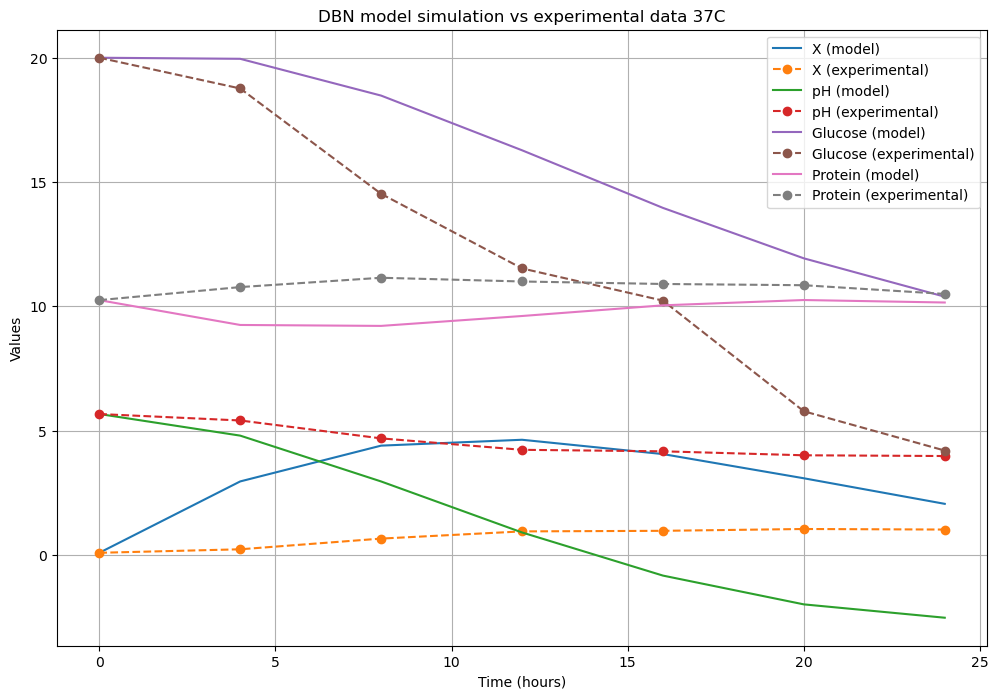

In [166]:
plt.figure(figsize=(12, 8))
for key in results:
    plt.plot(lb3_time_opticaldensity_ph_glucose_protein_37["Time"], results[key], label=key + ' (model)')
    plt.plot(
        lb3_time_opticaldensity_ph_glucose_protein_37["Time"],
        lb3_time_opticaldensity_ph_glucose_protein_37[key if key != 'X' else 'OpticalDensity'],
        'o--',
        label=key + ' (experimental)'
    )

plt.xlabel('Time (hours)')
plt.ylabel('Values')
plt.legend()
plt.title('DBN model simulation vs experimental data 37C')
plt.grid()
plt.show()

## Optimization part

In [167]:
def simulate(params, temperature: float = 1.0) -> tuple[np.ndarray, ...]:
    Xs, pHs, Gs, Bs = (
        [lb3_time_opticaldensity_ph_glucose_protein_37["OpticalDensity"].iloc[0]],
        [lb3_time_opticaldensity_ph_glucose_protein_37["pH"].iloc[0]],
        [lb3_time_opticaldensity_ph_glucose_protein_37["Glucose"].iloc[0]],
        [lb3_time_opticaldensity_ph_glucose_protein_37["Protein"].iloc[0]]
    )
    timestamps = len(lb3_time_opticaldensity_ph_glucose_protein_37) - 1

    for _ in range(timestamps):
        X, pH, G, B = Xs[-1], pHs[-1], Gs[-1], Bs[-1]

        X_next = (params[0] * X + params[1] * pH + params[2] * G + params[3] * B) * temperature
        pH_next = params[4] + params[5] * pH - params[6] * X_next
        G_next = G - params[7] * X_next  
        B_next = B + params[8] * X_next - params[9] * B
        
        Xs.append(X_next)
        pHs.append(pH_next)
        Gs.append(G_next)
        Bs.append(B_next)
    return np.array(Xs), np.array(pHs), np.array(Gs), np.array(Bs)


def loss(params):
    X_pred, pH_pred, G_pred, B_pred = simulate(params)

    X_obs = lb3_time_opticaldensity_ph_glucose_protein_37["OpticalDensity"].values
    pH_obs = lb3_time_opticaldensity_ph_glucose_protein_37["pH"].values
    G_obs = lb3_time_opticaldensity_ph_glucose_protein_37["Glucose"].values
    B_obs = lb3_time_opticaldensity_ph_glucose_protein_37["Protein"].values

    # Normalization
    _std = lambda a: float(np.std(a)) if float(np.std(a)) > 0 else 1.0
    std_X, std_pH, std_G, std_B = map(_std, (X_obs, pH_obs, G_obs, B_obs))

    rX = (X_pred - X_obs) / std_X
    rpH = (pH_pred - pH_obs) / std_pH
    rG = (G_pred - G_obs) / std_G
    rB = (B_pred - B_obs) / std_B

    err = np.sum(rX**2) + np.sum(rpH**2) + np.sum(rG**2) + np.sum(rB**2)
    print(err)
    return float(err)


def plot_model_vs_experimental(
    params,
    temp_mult: float = 1.0,
    temp_label: str = "37C",
    df: pd.DataFrame = lb3_time_opticaldensity_ph_glucose_protein_37,
    title_prefix: str = 'DBN model simulation vs experimental data',
    show: bool = True
):
    X_sim, pH_sim, G_sim, B_sim = simulate(params, temperature=temp_mult)
    sim = {'X': X_sim, 'pH': pH_sim, 'Glucose': G_sim, 'Protein': B_sim}
    if show:
        plt.figure(figsize=(12, 8))
        t = df["Time"].values
        for key, series in sim.items():
            plt.plot(t, series, label=f"{key} (model)")
            plt.plot(
                t,
                df[key if key != 'X' else 'OpticalDensity'].values,
                'o--',
                label=f"{key} (experimental)"
            )
        plt.xlabel('Time (hours)')
        plt.ylabel('Values')
        plt.legend()
        plt.title(f"{title_prefix} {temp_label}")
        plt.grid()
        plt.show()
    return sim


params = np.random.rand(14) * 0.01
res = minimize(loss, params, method='L-BFGS-B', options={'maxiter': 30_000})
print('Optimal params:', res.x)

357.75358039126735
357.75358026033445
357.75358036755296
357.7535700588793
357.75357509608875
357.75357909018237
357.7535788824305
357.75358072320574
357.7535803553204
357.75357964345613
357.7536103314838
357.75358039126735
357.75358039126735
357.75358039126735
357.75358039126735
4888304.588464353
4888304.590705569
4888304.589450107
4888304.595454212
4888304.601398072
4888304.588463514
4888304.588463908
4888304.588486638
4888304.587072661
4888304.704875524
4888304.297417801
4888304.588464353
4888304.588464353
4888304.588464353
4888304.588464353
14946.837363429962
14946.837370188094
14946.837368506938
14946.837434924539
14946.837422859899
14946.837362127242
14946.837361912874
14946.837366806894
14946.837361518406
14946.837678453767
14946.835436154899
14946.837363429962
14946.837363429962
14946.837363429962
14946.837363429962
335.0498502122086
335.04985006455365
335.04985035720745
335.0498432278541
335.04984642175515
335.04984891073747
335.0498487027282
335.04985073320074
335.04985015726

In [187]:
# X_model_temp35, pH_model_temp35, G_model_temp35, B_model_temp35 = simulate(res.x, temperature=0.976458)
# X_model_temp37, pH_model_temp37, G_model_temp37, B_model_temp37 = simulate(res.x)
# X_model_temp40, pH_model_temp40, G_model_temp40, B_model_temp40 = simulate(res.x, temperature=0.950491)
# X_model_temp45, pH_model_temp45, G_model_temp45, B_model_temp45 = simulate(res.x, temperature=0.814320)


X_model_temp35, pH_model_temp35, G_model_temp35, B_model_temp35 = simulate(res.x, temperature=0.4)
X_model_temp37, pH_model_temp37, G_model_temp37, B_model_temp37 = simulate(res.x)
X_model_temp40, pH_model_temp40, G_model_temp40, B_model_temp40 = simulate(res.x, temperature=0.3)
X_model_temp45, pH_model_temp45, G_model_temp45, B_model_temp45 = simulate(res.x, temperature=0.2)


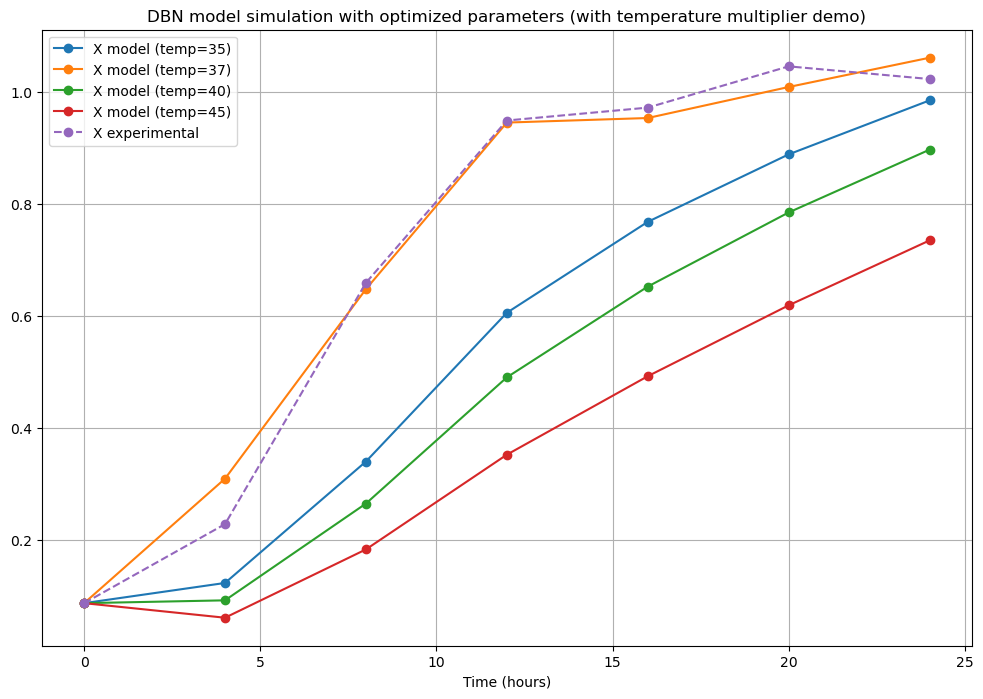

In [189]:
plt.figure(figsize=(12, 8))
plt.plot(lb3_time_opticaldensity_ph_glucose_protein_37['Time'], X_model_temp35, label='X model (temp=35)', marker='o')
plt.plot(lb3_time_opticaldensity_ph_glucose_protein_37['Time'], X_model_temp37, label='X model (temp=37)', marker='o')
plt.plot(lb3_time_opticaldensity_ph_glucose_protein_37['Time'], X_model_temp40, label='X model (temp=40)', marker='o')
plt.plot(lb3_time_opticaldensity_ph_glucose_protein_37['Time'], X_model_temp45, label='X model (temp=45)', marker='o')
plt.plot(lb3_time_opticaldensity_ph_glucose_protein_37['Time'], lb3_time_opticaldensity_ph_glucose_protein_37['OpticalDensity'], 'o--', label='X experimental')

plt.legend()
plt.xlabel('Time (hours)')
plt.title('DBN model simulation with optimized parameters (with temperature multiplier demo)')
plt.grid()
plt.show()

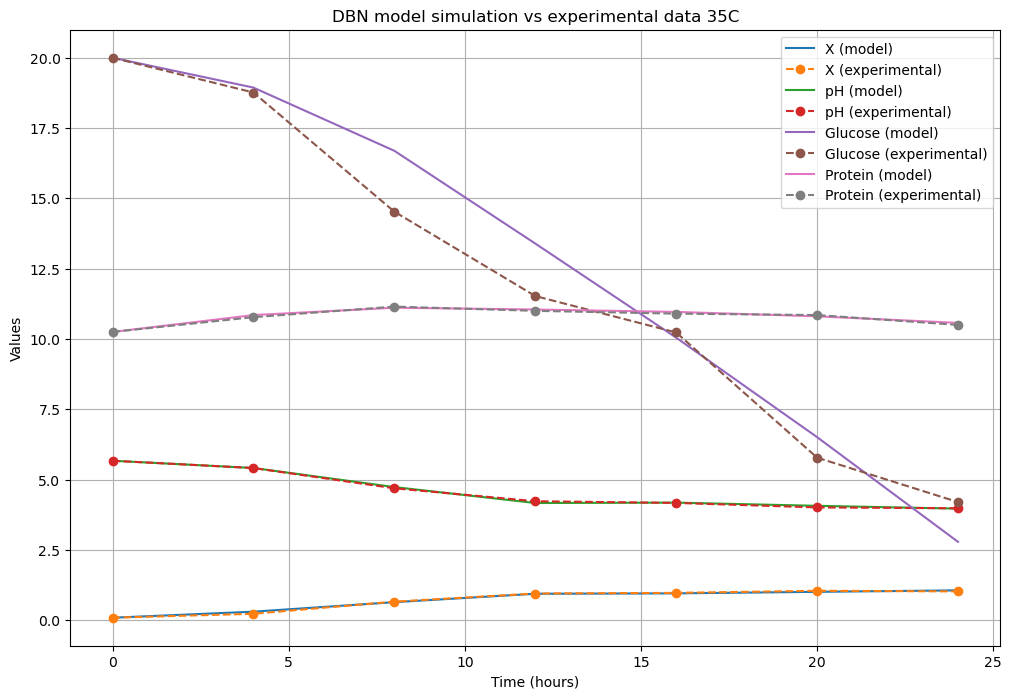

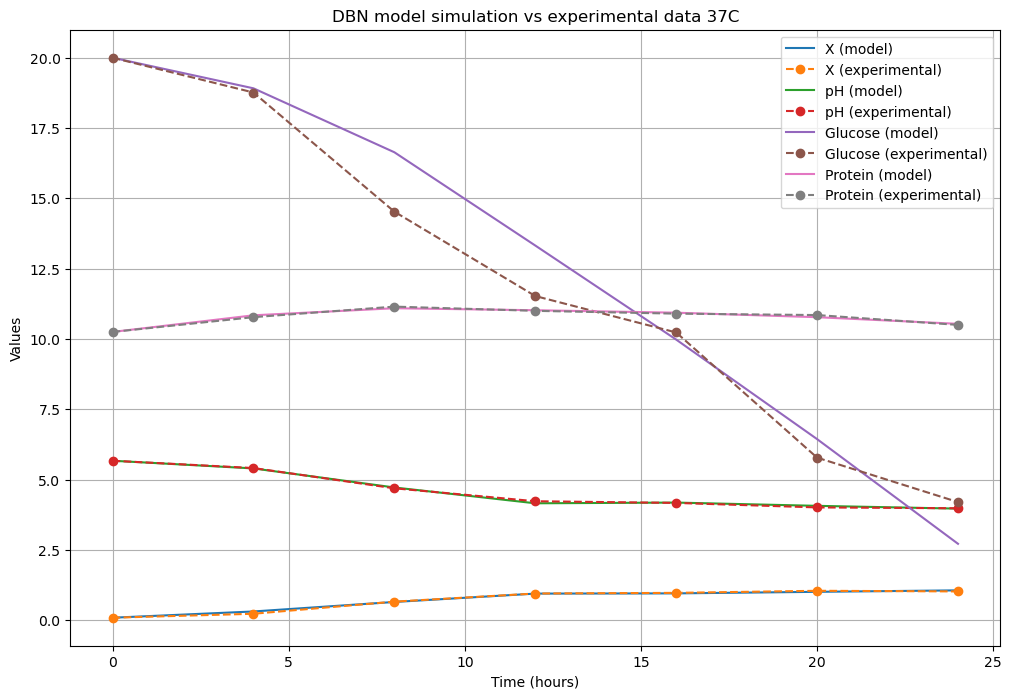

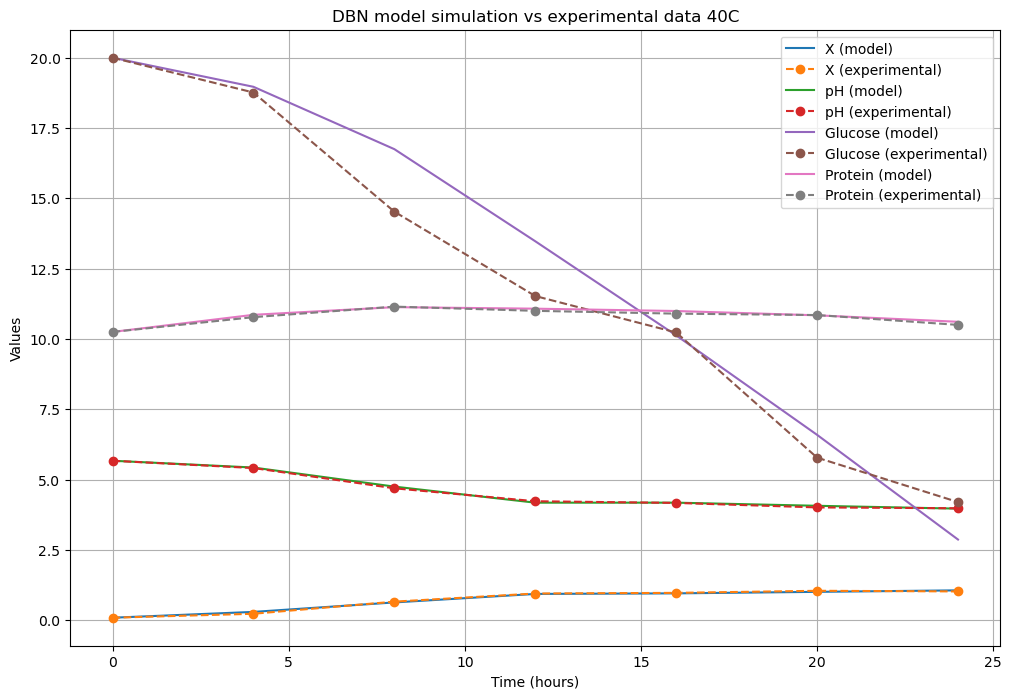

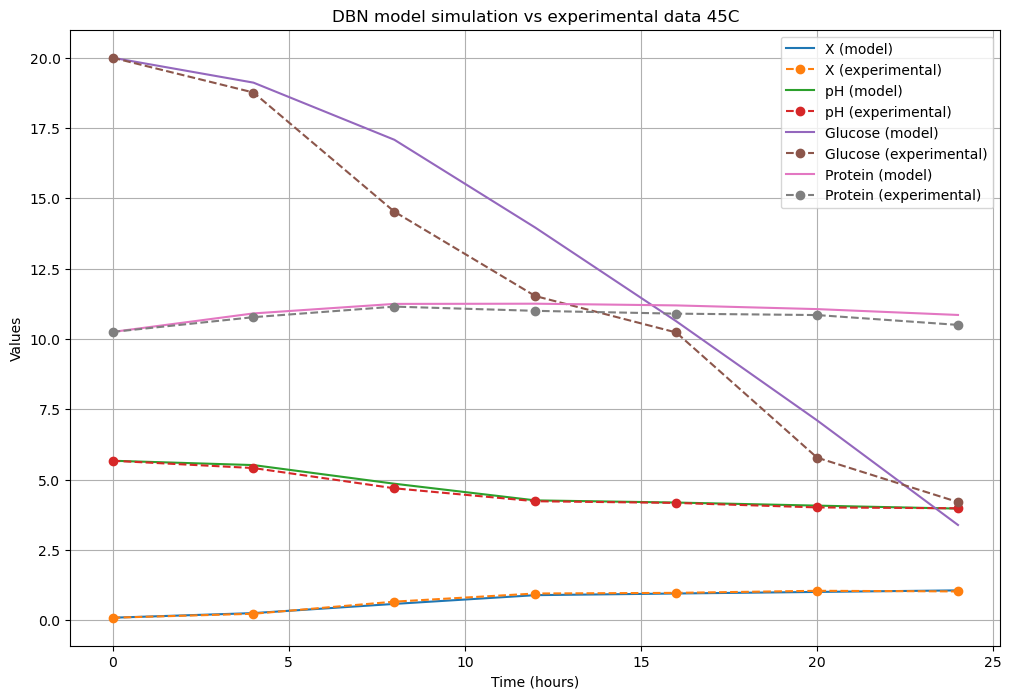

In [190]:
_TEMPERATURES = [
    ("35C", 0.976458),
    ("37C", 1.0),
    ("40C", 0.950491),
    ("45C", 0.814320),
]
all_sims = {}
for label, mult in _TEMPERATURES:
    all_sims[label] = plot_model_vs_experimental(
        res.x,
        temp_mult=mult,
        temp_label=label,
        title_prefix='DBN model simulation vs experimental data'
    )